In [1]:
from PIL import Image, ImageFilter
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torch.nn.functional as F
from scipy import ndimage
from skimage.measure import regionprops

/home/kafkaon1/miniconda3/envs/mlenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!curl ident.me

147.32.71.9

### Loss viz

In [4]:
def moving_average(a, n=8) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def visualize_logs(path):
    lg = np.load(path, allow_pickle=True)
    plt.figure(figsize=(20,10))
    runs = { metric_name: [] for metric_name, _ in lg[0].items() }
    for k,v in enumerate(lg):
        for metric_name, metric_value in v.items():
            runs[metric_name] = runs[metric_name] + metric_value
    for k,v in runs.items():
        v = moving_average(v)
        plt.plot(v, label=k)
    plt.legend()


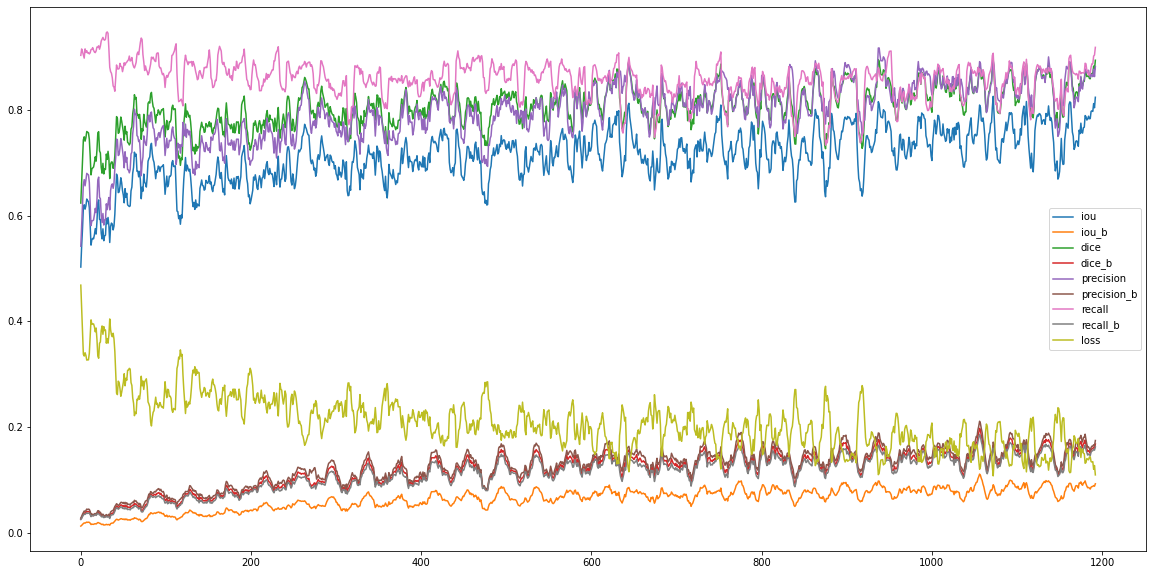

In [20]:
visualize_logs('/home/kafkaon1/FVAPP/out/run_230503-140231/logs/val_logs.npy')

In [3]:
img_path = '/home/kafkaon1/FVAPP/data/FV/train/image_resized/christchurch_450_478.png' #  '/home/kafkaon1/tmp_sataa.jpg'
label_path = '/home/kafkaon1/FVAPP/data/FV/train/label_resized/christchurch_450_478.png'
im = Image.open(img_path)
la = np.array(Image.open(label_path)).astype(float)

In [4]:
I = T.ToTensor()(im)#cv2.imread(img_path))
l = T.ToTensor()(la)
I = I.unsqueeze(0)
l = l.unsqueeze(0)


In [11]:
I.shape

torch.Size([1, 3, 640, 640])

### Loss development

The paper LF

In [29]:
# boundary map
gt_b = F.max_pool2d(
            1 - l, kernel_size=3, stride=1, padding=(3 - 1) // 2)
gt_b -= 1 - l

# extended boundary map
ks = 5
gt_b_ext = F.max_pool2d(
    gt_b, kernel_size=ks, stride=1, padding=(ks - 1) // 2)


In [16]:
im = T.ToPILImage()(gt_b[0,0,:,:])
im_ext = T.ToPILImage()(gt_b_ext[0,0,:,:])

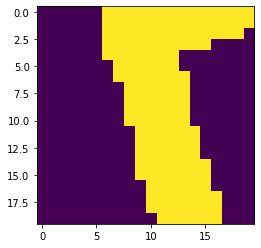

In [30]:
plt.imshow(gt_b_ext[0,0,55:75,65:85])

My LF

In [34]:
t = l[:,:,350:500,50:200]

In [31]:
gb = T.GaussianBlur(9)

In [35]:
# i need to pad the t tensor with zeros before conv2d

#t_p = F.pad(t, (5, 5, 5, 5), mode='constant', value=0)  # pad with ones

gt_d = gb(t)
#gt_d = F.conv2d(
 #           1-t_p, torch.ones([1,1,11,11]).double(), stride=1)

gt_d *= 1-t

In [36]:
im = T.ToPILImage()(gt_d[0,0,:,:])

In [37]:
h = np.array(im.histogram()) 

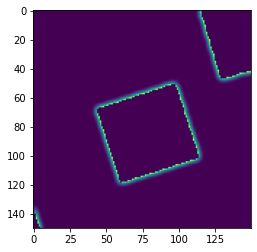

In [38]:
plt.imshow(np.array(im))

My LF2

In [14]:
# boundary map
gt_b = F.max_pool2d(
            1 - l, kernel_size=3, stride=1, padding=(3 - 1) // 2)
gt_b -= 1 - l


In [19]:
gb = T.GaussianBlur(9)

In [20]:
gt_bb = gb(gt_b)

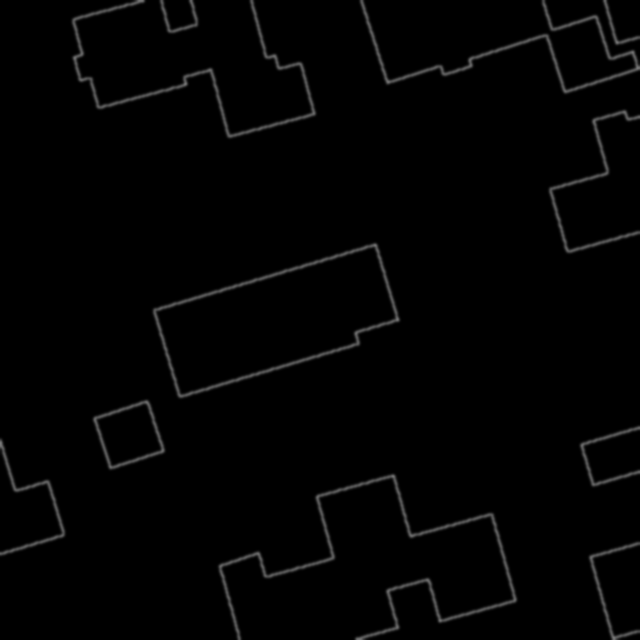

In [21]:
T.ToPILImage()(gt_bb[0,0,:,:])

In [33]:
loss = torch.nn.BCELoss(reduction='none')


intermediate_losses = loss((1-l).float(), l.float())


### Model results

In [40]:
model1 = torch.load('/home/kafkaon1/FVAPP/out/train/run_230517-134445/checkpoints/Deeplabv3_err:0.01578_ep:17.pth', map_location=torch.device('cpu'))
torch.no_grad()
model1.eval()
print(".")

.


In [41]:
out = model1(I)

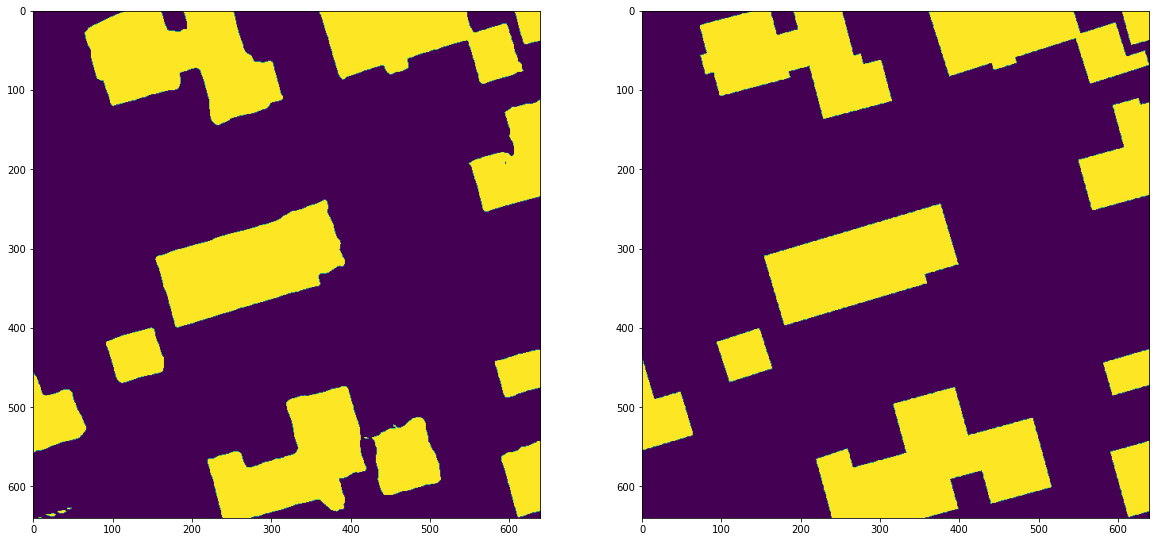

In [42]:
fig, ax = plt.subplots(1,2 ,figsize=(20,10))
ax[0].imshow((out[0,0]>0.5).detach().numpy())
ax[1].imshow(la)

### Regularization and polygon fitting

#### Regularization from paper

In [3]:
sys.path.append("./third_party")
from projectRegularization import regularization2

In [20]:
MODEL_ENCODER = "/home/kafkaon1/FVAPP/third_party/projectRegularization/saved_models_gan/E140000_e1"
MODEL_GENERATOR = "/home/kafkaon1/FVAPP/third_party/projectRegularization/saved_models_gan/E140000_net"

in_mode="semantic"
out_mode="semantic"
samples=None


In [21]:
P = np.array(Image.open(img_path))

M = (out[0,0]>0.5).numpy().astype(np.uint8)

R = regularization2(P, M, MODEL_GENERATOR, MODEL_ENCODER, in_mode, out_mode)


Regularization: 100%|██████████| 12/12 [00:00<00:00, 26.78it/s]


NameError: name 'R' is not defined

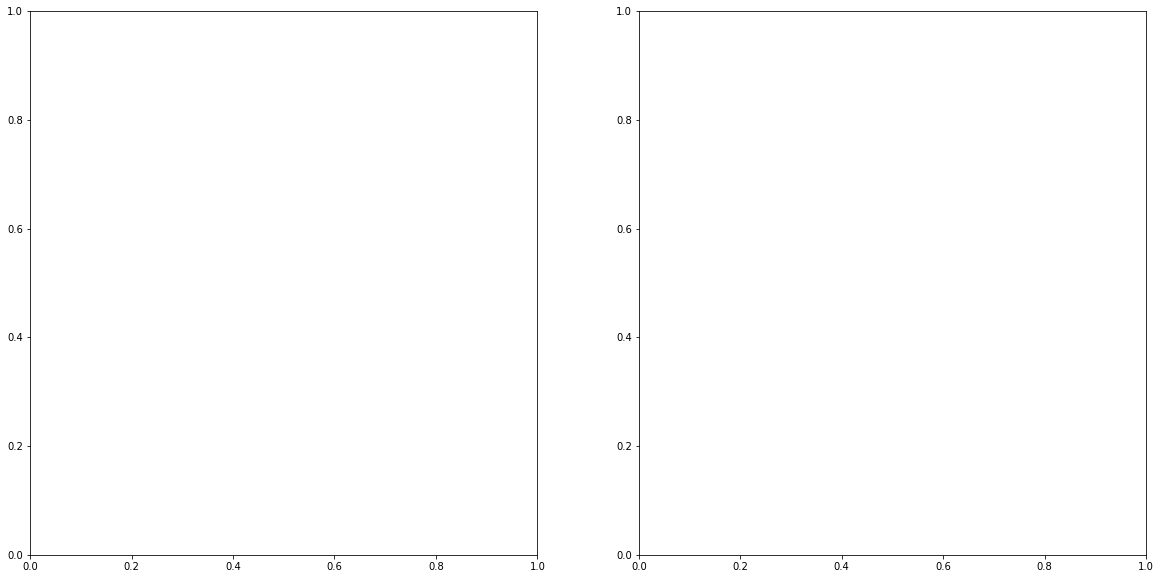

In [5]:
fig, ax = plt.subplots(1,2 ,figsize=(20,10))
ax[0].imshow(R)
ax[1].imshow(la)

#### Polygon fitting

Hough transform

In [9]:
image_out = T.ToPILImage()(((out[0,0]>0.5)).float())

In [ ]:
image_out = T.ToPILImage()(((out[0,0]>0.5)).float())

In [ ]:
iamge_out

In [18]:
lab = image_out.filter(ImageFilter.FIND_EDGES)

In [20]:
minLineLength = 100
maxLineGap = 30

In [21]:
lb = np.array(lab)

In [22]:
lines = cv2.HoughLinesP(lb,1,np.pi/180,30,minLineLength,maxLineGap)

In [23]:
cdst = cv2.cvtColor(lb, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

In [24]:
for i in range(0, len(lines)):
    l = lines[i][0]
    cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

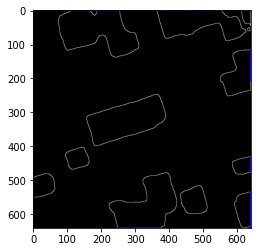

In [25]:
plt.imshow(cdstP)

PolyfitDP

In [35]:
imagoa = np.array(image_out)
cdst = cv2.cvtColor(imagoa, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

In [71]:
output_filtered = np.copy(np.array(image_out))
positive_label_areas = np.zeros((output_filtered.shape[0], output_filtered.shape[1]), dtype=np.uint8)
positive_label_areas[np.where(output_filtered == 255)] = 1

# Generate a label mask that assigns a unique label to each positive area
label_mask, num_labels = ndimage.label(positive_label_areas)

label = label_mask[320, 320]

output_filtered[np.where(label_mask != label)] = 0

# labeled_arr, num_labels = ndimage.label(arr)

# get bounding boxes of connected components
regions = regionprops(label_mask)
bbx = regions[label].bbox

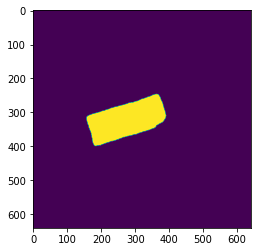

In [72]:
plt.imshow(output_filtered)

In [61]:

contours, _ = cv2.findContours(output_filtered, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
epsilon = 0.005*cv2.arcLength(cnt,True)

In [62]:
approx = cv2.approxPolyDP(cnt,epsilon,True)

In [63]:
cdsat = cv2.cvtColor(output_filtered, cv2.COLOR_GRAY2BGR)
cdstPa = np.copy(cdsat)

In [64]:
# cv2.drawContours(cdstP, [cnt], -1, (0,255,255), 3)
cv2.drawContours(cdstPa, [approx], -1, (0,0,255), 3)
print(".")

.


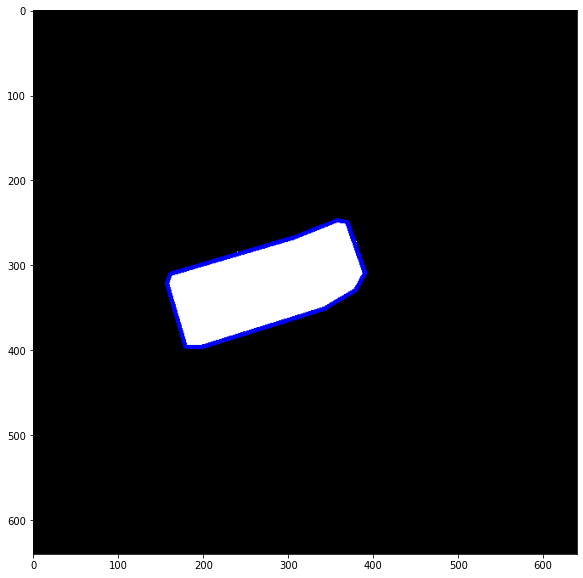

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(cdstPa)

Implementation of PolyCNN

In [9]:
sys.path.append("./third_party/")
from PolyWorldPretrainedNetwork import predict_single

In [12]:
I

tensor([[[[0.3373, 0.3255, 0.3255,  ..., 0.8588, 0.8627, 0.8588],
          [0.3333, 0.3333, 0.3373,  ..., 0.8706, 0.8706, 0.8549],
          [0.3451, 0.3529, 0.3569,  ..., 0.8784, 0.8706, 0.8510],
          ...,
          [0.3020, 0.3255, 0.3451,  ..., 0.1137, 0.1490, 0.1412],
          [0.3804, 0.3922, 0.3569,  ..., 0.3882, 0.4863, 0.4039],
          [0.8275, 0.8078, 0.7529,  ..., 0.4353, 0.5059, 0.4039]],

         [[0.3882, 0.3765, 0.3765,  ..., 0.8431, 0.8471, 0.8431],
          [0.3804, 0.3804, 0.3843,  ..., 0.8549, 0.8549, 0.8392],
          [0.3922, 0.4000, 0.4039,  ..., 0.8627, 0.8549, 0.8353],
          ...,
          [0.3059, 0.3333, 0.3451,  ..., 0.1529, 0.1922, 0.1882],
          [0.3882, 0.3961, 0.3608,  ..., 0.4314, 0.5294, 0.4510],
          [0.8235, 0.8000, 0.7412,  ..., 0.4824, 0.5569, 0.4549]],

         [[0.2471, 0.2353, 0.2353,  ..., 0.8471, 0.8510, 0.8471],
          [0.2392, 0.2392, 0.2431,  ..., 0.8588, 0.8588, 0.8431],
          [0.2431, 0.2549, 0.2627,  ..., 0

In [14]:
p = predict_single(I.cuda())

[{'image_id': 0,
  'category_id': 100,
  'score': 1,
  'segmentation': [[60.0,
    591.5625,
    149.0625,
    599.0625,
    137.8125,
    588.75,
    591.5625,
    49.6875,
    314.0625,
    350.625,
    347.8125,
    144.375,
    587.8125,
    38.4375,
    295.3125,
    61.875,
    456.5625,
    110.625,
    587.8125,
    391.875,
    454.6875,
    589.6875,
    101.25,
    192.1875,
    130.3125,
    195.9375,
    599.0625,
    18.75,
    595.3125,
    105.0,
    586.875,
    502.5,
    569.0625,
    26.25,
    571.875,
    107.8125,
    584.0625,
    103.125,
    583.125,
    442.5,
    590.625,
    0.0,
    463.125,
    593.4375,
    566.25,
    67.5,
    599.0625,
    270.9375,
    598.125,
    4.6875,
    589.6875,
    88.125,
    595.3125,
    405.0,
    594.375,
    32.8125,
    542.8125,
    478.125,
    383.4375,
    482.8125,
    593.4375,
    403.125,
    386.25,
    143.4375,
    286.875,
    41.25,
    366.5625,
    258.75,
    592.5,
    488.4375,
    585.0,
    0.0,
  

Implementation of SAM

In [12]:
sys.path.append("./third_party/segment-anything/")
from segment_anything import sam_model_registry, SamPredictor

In [13]:
sam_checkpoint = "/home/kafkaon1/FVAPP/third_party/segment-anything/wghs.pth"
model_type = "vit_h"

device = "cuda:1"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [67]:
image = np.array(Image.open(img_path))

In [68]:
predictor.set_image(image)

In [78]:
output_filtered.shape

(640, 640)

In [74]:
input_box = np.array([94, 166, 402, 468])

In [75]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


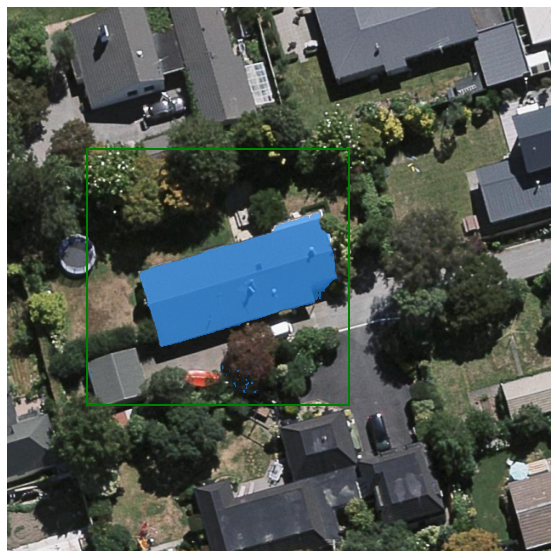

In [76]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()